In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# -------------------------------------------------------------------------------

import scipy.stats as stats
from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
from src import soporte as sp

In [4]:
customer_final = pd.read_csv('/Users/rosana/Desktop/customer_final.csv')
customer_final.head(3)

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0,2017,1,0,0,0,0,0.0,0,0
1,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0,2017,2,3,0,3,2823,282.0,0,0
2,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0.0,0.0,2017,3,0,0,0,0,0.0,0,0


# BONUS   

## Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

Utilizando un conjunto de datos que hemos compartido, se busca evaluar si existen diferencias significativas en el número de vuelos reservados según el nivel educativo de los clientes.

#### 1. Preparación de Datos:

Filtra el conjunto de datos para incluir únicamente las columnas relevantes: 'Flights Booked' y 'Education'.

In [5]:
bonus = customer_final[['flights_booked','education']]

bonus

,flights_booked,education
0,0,Bachelor
1,3,Bachelor
2,0,Bachelor
3,0,Bachelor
4,6,Bachelor
...,...,...
403755,0,Bachelor
403756,0,Bachelor
403757,0,Bachelor
403758,0,Bachelor


#### 2. Análisis Descriptivo:

Agrupa los datos por nivel educativo y calcula estadísticas descriptivas básicas (como el promedio, la desviación estandar) del número de vuelos reservados para cada grupo.

In [6]:
# Agrupar por educación y calcular varias estadísticas

education_levels = bonus.groupby('education').agg(['mean', 'median', 'std', 'var']).reset_index()

education_levels

education flights_booked                            
                                  mean median       std        var
0              Bachelor       4.110288    1.0  5.221671  27.265843
1               College       4.169744    1.0  5.246040  27.520938
2                Doctor       4.175512    1.0  5.256971  27.635748
3  High School or Below       4.176209    1.0  5.239267  27.449915
4                Master       4.200700    1.0  5.213956  27.185339

Observaciones:

- Los promedios de vuelos reservados son bastante similares entre todos los niveles educativos (alrededor de 4 vuelos).

- La desviación estándar también es bastante similar entre los grupos, lo que indica que la variabilidad en el número de vuelos reservados es bastante constante entre los diferentes niveles educativos.

- Los mínimos son 0, lo que indica que algunos clientes no reservaron ningún vuelo.

- Los máximos (21) indican que, para cada grupo educativo, el número máximo de vuelos reservados por un cliente es 21.

#### 5. **Prueba Estadística:** Realiza una prueba de hipótesis para determinar si existe unas diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

##### Objetivo del A/B Testing:

Determinar si existe una diferencia significativa en el número de vuelos reservados (flights_booked) entre los dos grupos de educación que vamos a crear: `low_education` y `high_education`. Para ello creamos la columna `education_group` con los dos grupos categorizados utilizando el método `np.select()` de numpy, que permite asignar valores según condiciones, para hacerlo de manera sencilla.


Nos plantearemos las siguientes hipótesis:

- **Hipótesis nula (H₀):** No hay diferencia significativa en el número de vuelos reservados entre los dos grupos que hemos creado.

- **Hipótesis alternativa (H₁):** Existe una diferencia significativa en el número de vuelos reservados entre los dos grupos.



In [7]:

# Crear condiciones para los grupos
# np.select(): Aplica las condiciones al DataFrame y crea la nueva columna 'education_group' con los valores definidos.

conditions = [
    (bonus['education'].isin(['Bachelor', 'Master', 'Doctor'])),  # Universitarios
    (bonus['education'].isin(['College','High School or Below']))  # No Universitarios
]

# Asignar valores según las condiciones
choices = ['university', 'non_university']

# Crear la nueva columna 'education_group'
bonus['education_group'] = np.select(conditions, choices, default='Unknown')

# Verificar el resultado
bonus[['flights_booked', 'education_group']]


,flights_booked,education_group
0,0,university
1,3,university
2,0,university
3,0,university
4,6,university
...,...,...
403755,0,university
403756,0,university
403757,0,university
403758,0,university


In [8]:
print("Grupo de univesitarios:")
sp.normalidad(bonus[bonus['education_group'] == 'non_university'], 'flights_booked')

Grupo de univesitarios:
Para la columna flights_booked los datos no siguen una distribución normal.


In [9]:
print("Grupo de no univesitarios:")
sp.normalidad(bonus[bonus['education_group'] != 'non_university'], 'flights_booked')

Grupo de no univesitarios:
Para la columna flights_booked los datos no siguen una distribución normal.


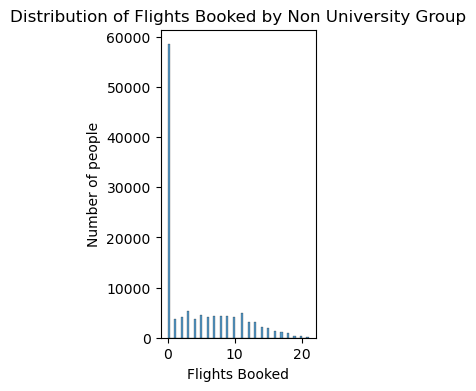

In [10]:

# Con un histograma podemos comprobar que el resultado del test anterior es correcto: los datos no siguen una distribución normal.

plt.figure(figsize=(2, 4))

sns.histplot(x='flights_booked', data=bonus[bonus['education_group'] == 'non_university'], palette='viridis')

plt.title('Distribution of Flights Booked by Non University Group')
plt.xlabel('Flights Booked')
plt.ylabel('Number of people')
plt.show()


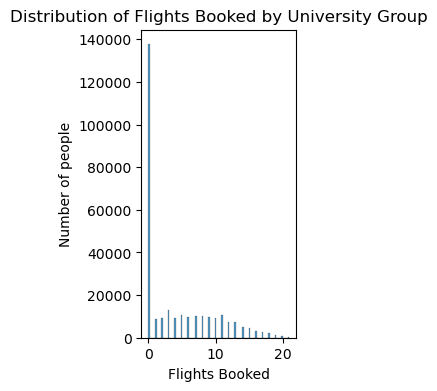

In [11]:

# Con un histograma podemos comprobar que el resultado del test anterior es correcto: los datos no siguen una distribución normal.

plt.figure(figsize=(2, 4))

sns.histplot(x='flights_booked', data=bonus[bonus['education_group'] != 'non_university'], palette='viridis')

plt.title('Distribution of Flights Booked by University Group')
plt.xlabel('Flights Booked')
plt.ylabel('Number of people')
plt.show()


Nuestros datos no cumplen el supuesto de normalidad, por lo que tendremos que optar por una prueba estadística no paramétrica: el **Test de Mann Whitney**.  

Este test es una prueba utilizada para comparar dos muestras independientes y determinar si provienen de poblaciones con medianas iguales o diferentes. Es apropiada cuando los datos no siguen una distribución normal y se utiliza para evaluar si hay diferencias significativas entre dos grupos. 

Esta prueba nos devuelve el valor p (p-value), que indica cuán significativas son las diferencias entre las muestras: un valor p pequeño sugiere que las medianas son significativamente diferentes.

Para interpretar los resultados:

- Si p-value < 0.05, sugiere que hay diferencias significativas entre las medianas de las muestras.

- Si p-value > 0.05, sugiere que no hay evidencia suficiente para concluir que las medianas son diferentes.

In [12]:

# Filtrar los grupos por nivel educativo

non_uni = bonus[bonus['education_group'] == 'non_university']['flights_booked']
uni = bonus[bonus['education_group'] != 'non_university']['flights_booked']

# Realizar la prueba de Mann-Whitney 
_, p_value = mannwhitneyu(non_uni, uni)

# Imprimir el valor p
print(f'El p_value de la prueba de Mann-Whitney es: {p_value}')


El p_value de la prueba de Mann-Whitney es: 0.0029420812621205176


In [13]:
p_value < 0.05

True

El resultado de nuestra prueba nos devuelve un p_value menor que 0,05; por lo tanto podemos concluir que, aunque se comporten de manera parecida, existe diferencia significativa entre los dos grupos.